In [1]:
from jax import make_jaxpr
import jax.numpy as jnp
import numpy as np
import jax
from jax import lax, grad, jit

/Users/mallikarjunswamy/miniforge3/envs/.conda/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
size = 10
a = jnp.ones((size, size))
b = jnp.ones((size, size))
gt = jnp.ones((size, size)) * 2

In [3]:
def mat_add(a, b):
    c = jnp.zeros(a.shape)
    row, col = a.shape
    for i in range(row):
        for j in range(col):
            c = c.at[i, j].set(a[i, j] + b[i, j])
    return c

def loss_fn(a, b, gt):
    return jnp.mean((mat_add(a, b) - gt)**2)

In [4]:
%timeit -n 5 mat_add(a, b).block_until_ready()
%timeit -n 5 grad(loss_fn)(a, b, gt).block_until_ready()

141 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
276 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [5]:
@jax.jit
def mat_add_jit(a, b):
    c = jnp.zeros(a.shape)
    row, col = a.shape
    for i in range(row):
        for j in range(col):
            c = c.at[i, j].set(a[i, j] + b[i, j])
    return c

@jax.jit
def loss_fn_jit(a, b, gt):
    return jnp.mean((mat_add_jit(a, b) - gt)**2)

In [6]:
%timeit -n 5 mat_add_jit(a, b).block_until_ready()
%timeit -n 5 grad(loss_fn_jit)(a, b, gt).block_until_ready()

The slowest run took 30642.41 times longer than the fastest. This could mean that an intermediate result is being cached.
17.2 ms ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 987.20 times longer than the fastest. This could mean that an intermediate result is being cached.
677 ms ± 1.65 s per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [7]:
def mat_add_lax(a, b):
    c = jnp.zeros(a.shape)
    row, col = a.shape
    
    def inner_loop(i, c):
        ii, jj = i // col, i % col
        return c.at[ii, jj].set(a[ii, jj] + b[ii, jj])
    return lax.fori_loop(0, row * col,  inner_loop, c)

def loss_fn_lax(a, b, gt):
    return jnp.mean((mat_add_lax(a, b) - gt)**2)

In [8]:
%timeit -n 5 mat_add_lax(a, b).block_until_ready()
%timeit -n 5 grad(loss_fn_lax)(a, b, gt).block_until_ready()

31.4 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
107 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [9]:
def mat_add_lax_jit(a, b):
    c = jnp.zeros(a.shape)
    row, col = a.shape
    
    def inner_loop(i, c):
        ii, jj = i // col, i % col
        return c.at[ii, jj].set(a[ii, jj] + b[ii, jj])
    return lax.fori_loop(0, row * col,  inner_loop, c)

def loss_fn_lax_jit(a, b, gt):
    return jnp.mean((mat_add_lax(a, b) - gt)**2)

In [10]:
mat_add_lax_jit = jit(mat_add_lax_jit)
loss_fn_lax_jit = jit(loss_fn_lax_jit)

%timeit -n 5 mat_add_lax_jit(a, b).block_until_ready()
%timeit -n 5 grad(loss_fn_lax_jit)(a, b, gt).block_until_ready()

The slowest run took 2563.90 times longer than the fastest. This could mean that an intermediate result is being cached.
961 µs ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 41.51 times longer than the fastest. This could mean that an intermediate result is being cached.
3.56 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [11]:
mat_add_lax_jit_ = jit(mat_add_lax_jit)
loss_fn_lax_jit_ = jit(grad(loss_fn_lax_jit))

%timeit -n 5 mat_add_lax_jit_(a, b).block_until_ready()
%timeit -n 5 loss_fn_lax_jit_(a, b, gt).block_until_ready()

The slowest run took 2535.01 times longer than the fastest. This could mean that an intermediate result is being cached.
987 µs ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
The slowest run took 3620.75 times longer than the fastest. This could mean that an intermediate result is being cached.
2.87 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [5]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


key = random.PRNGKey(0)

In [ ]:
def add_scalar(a, b):
   return a + b

%timeit -n 5 vmap(add_scalar, in_axes=(0, 0))(a.flatten(), b.flatten()).block_until_ready()

(7, 7)
(768, 1024)


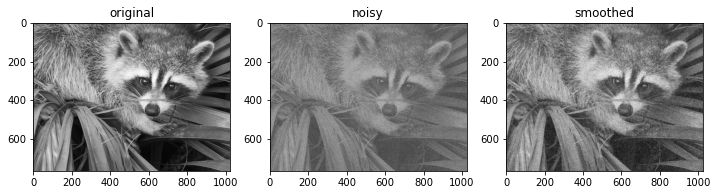

In [23]:
from scipy import misc
import jax.scipy as jsp
import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Load a sample image; compute mean() to convert from RGB to grayscale.
image = jnp.array(misc.face().mean(-1))
ax[0].imshow(image, cmap='binary_r')
ax[0].set_title('original')

# Create a noisy version by adding random Gausian noise
key = random.PRNGKey(1701)
noisy_image = image + 50 * random.normal(key, image.shape)
ax[1].imshow(noisy_image, cmap='binary_r')
ax[1].set_title('noisy')

# Smooth the noisy image with a 2D Gaussian smoothing kernel.
x = jnp.linspace(-3, 3, 7)
# print(x.shape)
# print(x)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])

print(window.shape)
# print(window)
print(noisy_image.shape)
smooth_image = jsp.signal.convolve(noisy_image, window, mode='same')
ax[2].imshow(smooth_image, cmap='binary_r')
ax[2].set_title('smoothed');

In [33]:
from jax import jit, lax
import jax.numpy as jnp

def multiple_iter():
    def single_iter(i, data):
        data = jnp.pad(data, i)
        return data
    
    data = jnp.zeros((5, 5))
    lax.fori_loop(
        1, 5, single_iter, data
    )
multiple_iter()

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
pad_width argument of jnp.pad
While tracing the function scanned_fun at /Users/mallikarjunswamy/miniforge3/envs/.conda/lib/python3.9/site-packages/jax/_src/lax/control_flow.py:148 for scan, this concrete value was not available in Python because it depends on the value of the argument 'loop_carry'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [34]:
from jax import jit, lax
import jax.numpy as jnp

def multiple_iter():
    def single_iter(i, data):
        data = jnp.pad(data, i)
        return data
    
    data = jnp.zeros((5, 5))
    
    single_iter_jit = jit(single_iter, static_argnums=0)
    lax.fori_loop(
        1, 5, single_iter_jit, data
    )
multiple_iter()

ValueError: Non-hashable static arguments are not supported, as this can lead to unexpected cache-misses. Static argument (index 0) of type <class 'jax.interpreters.partial_eval.DynamicJaxprTracer'> for function single_iter is non-hashable.